In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numba
import numpy as np
from numpy.typing import ArrayLike
from pympler import asizeof
import scipy as sp
from scipy.sparse import coo_matrix, csr_matrix, csr_array
from scipy.sparse.linalg import cg, gmres, LinearOperator
import timeit

# Part1

In this notebook, a subclass of the scipy's LinearOperator is created. It accepts scipy.sparse.coo_matrix object as an input and stores it in the csr format. The coo and csr [1] are two popular sparse matrix formats. In both of them, the idea is to keep only non zero elements, which often can significantly reduce amount of memory needed to store a matrix. In the coo format, shape and three arrays of values are needed to represent a matrix: an array containing non zero elements, called 'data', array of their row positions within a matrix, called 'row', and an array of their column positions within a matrix called 'col'. A csr format is similar, it also requires shape information, as well as three arrays for proper matrix representations. Similarly to coo, it also contains non zero elements inside a 'data' array and the column positions are kept inside an array called 'indices'. The biggest difference is that instead of keeping row positions, it uses an array called 'indptr' which contains information as to which elements from the indices array are associated with which rows. Indptr achieves that by keeping values of indices at which each row starts. Indptr always begins at 0, and its final element should be a number of elements inside the indices array (which should be equal to the number of elements inside the data array). This requires that indices array (containing column positions) is sorted by row. For example indptr array which begins as: [0, 5, ...] would mean that first 5 elements in indices and data arrays lie in the first row of a matrix (indices[0:5] and data[0:5] in this case). In contrary, coo format does not require any kind of ordering of its elements, as long as correct data values are associated together with their correct row and column positions inside the matrix. 

The class defined in this notebook, CSRMatrix, is a subclass of scipy.sparse.linalg.LinearOperator. It takes coo_matrix object and stores its representation in csr format. It is useful to notice that data arrays need to be the same in both formats. Additionally, col array in coo format is equivalent to indices array in csr. As mentioned earlier however, the CSRMatrix class needs to also handle the case when coo matrix input does not have any kind of ordering in its data, row, col arrays. To achieve that, np.argsort is used to obtain index ordering of rows, then rows, indices and data are sorted accordingly.

The row array still needs to be converted to indptr format. In order to do that, it needs to be counted how often each row occurs. The indptr starts at 0 and for every row, a value equal to its last value increased by number of occurances of this row is appended. 

As explained in [2], subclass of LinearOperator should either include a _matvec or a _matmat method. In this case, the CSRMatrix class is defined together with _matvec method for matrix - vector product, as well as with an \_\_add\_\_ method for matrix addition. 

### \_\_add\_\_ method
This performs standard matrix addition, it overloads '+' and allows for two CSRMatrix objects to be added together. In the code below, it is done entirely in the csr format, without converting to the coo. 
The general idea is to conduct operations row by row. Selecting ith and (i+1)th elements from indptr list allows to find positions of indices and data elements at ith row. This is done for both matrices, so that a row can be added to a row from another matrix. If matrices do not have any non zero values at exactly the same (row, column) position, the addition would just involve appending lists. However since this is only the case on special ocassions, the code needs to find positions shared by both matrices and instead of appending a data value, it needs to be added to the other value at the same position. In order to do that efficiently, a method is implemented inspired by the mergesort algorithm. The idea is to, for a given row sort indices of both matrices, and then for this row create a single sorted indices array (indices_atrow) without duplicates. Sorting indices from both arrays at row, means that while appending new element to this single new array of indices, just two values need to be compared: the last unappended element from indices from matrix 1 and the last unappended element from indices from matrix 2 at this row. To compute addition of matrices, there is also need to create single data array at current row. Therefore the idea is to create pointers, called in code below indices1_ptr and indices_2ptr, which point to the position (index) of the last unappended indices array element for matrix 1 and matrix 2 (at current row), and those values need to be compared. There are 3 main cases that need to be considered:
1. If indices1_ptr or indices2_ptr are greater than number of elements in indices arrays for matrix 1 or 2 respectively, then it means indices and data from only one matrices are left and they need to be appended at the end of their respective arrays. 
2. If index at position of its pointer from either of the matrices is smaller, then this index needs to be added at the end of the total indices at row array, and data element from this matrix at position of its current pointer is similarly added at the end of the data_atrow array. 4
3. If indices at current pointers are the same, then this indicates duplicate (the same index for the same row). Data elements at positions of two pointers need to be added together and appended at the end of the data_atrow array, and only one of the indices that were compared needs to be added at the end of the indices_atrow (as they are the same).
After that, for each row, new indptr element is computed by adding length of the indices_atrow array to the previous indptr value.

At the end, all indices_atrow and data_atrow are connected into single arrays representing data and indices in csr format of the added matrices.
This ensures duplicates are properly handled, and as bonus results in indices at given row being sorted after addition. 

At the end of this procedure, three arrays are produced which represent matrix in the csr format as usual: data, indices, indptr. They could just be returned at the end, but I decided to create a separate class that would store them in an object form.  

### _matvec method
This performs matrix (sotred as CSRMatrix object) - vector product, where the vector can be dense. This method is implemented in the csr format. The idea is to perform operations row by row. For a given row, there are given data array elements with their respective indices (columns) positions. Each of those elements needs to be multiplied by vector element at position inside the vector equal to column position of this element inside the matrix. The resulting values for a given row are summed together and thus ith element of the output vector is obtained, where i is current matrix row. This is achieved with np.dot. Alternatively this could be done as standard ndarray multiplication and then summed, but only the first approach allows to further speed it up with Numba.


### coo vs csr formats
As explained before, the difference between the coo and the csr is that the latter holds pointers to columns which tell where in the columns array (called indices in csr format), a new row starts. The data array needs to contain the same number of elements as there are non zero values in a matrix. In the coo, arrays constining columns and rows have the same number of elements as the data array. In contrary, in the csr format, indptr array always has number of elements equal to number of rows inside a matrix + 1, while the indices array also has the same length as data. 
Therefore, in case of dense or almost dense matrix, with few non zero elements, the three coo arrays will scale as $\sim O(n^2)$, while in csr only two arrays would scale this way, and indptr would grow as $O(n)$. In different example, for diagonal matrix, both representations would scale linearly with matrix size n. In the case where matrix has some number of elements L, which is much smaller than matrix size n, the coo representation will contain 3L values, while csr format will need to contain 2L numbers for non zero elements and n+1 indptr elements (although a lot of those would have the same value). In such scenario coo format would grow with matrix size as $ O(1)$ (assuming constant number of non zero elements L), while csr as $O(n)$. Those simple examples are exaggerated but they illustrate that the difference between those two formats and that one or the other might be more useful depending on the situation. 

In [2]:
# class to store matrix data in the csr format.
@dataclass
class Store_CSR:
    data: ArrayLike
    indices: ArrayLike
    indptr: ArrayLike
    shape: tuple
    dtype: np.dtype

In [3]:
@numba.njit(
    numba.types.Tuple(
        (  # output types: [::1] means numpy array in C style ordering
            numba.types.List(numba.float64[::1]),
            numba.types.List(numba.int32[::1]),
            numba.types.List(numba.int64),
        )
    )(  # input types: data arrays are arrays of floats, indices and indptr are arrays of integers
        numba.float64[:],
        numba.int32[:],
        numba.int32[:],
        numba.float64[:],
        numba.int32[:],
        numba.int32[:],
    )
)
def add_csr_merge(
    self_data, self_indices, self_indptr, other_data, other_indices, other_indptr
):
    """Performs addition in the csr format: given data, indices and indptr arrays from two matrices representations in the csr,
    add them together, carefully handling duplicate positions in matrix"""
    ptr_atrow = 0  # element of indptr array, it starts at zero and increment should be number of indices at row
    indptr_list = [np.int32(0)]  # initiate list of indptr with int32 0
    indices_list = [
        np.zeros(0, dtype=np.int32)
    ]  # initiate indices and data lists with zeros, indices are integers but data can be floats
    data_list = [np.zeros(0, dtype=np.float64)]

    # loop over rows
    for i in range(len(self_indptr) - 1):
        # find indices where current row starts and ends for first matrix
        ix1 = self_indptr[i]
        ix2 = self_indptr[i + 1]

        # indices and data for current row for first matrix
        indices1_in_row = np.copy(self_indices[ix1:ix2])
        data1_in_row = np.copy(self_data[ix1:ix2])

        # similarily for second matrix
        ix1 = other_indptr[i]
        ix2 = other_indptr[i + 1]
        indices2_in_row = np.copy(other_indices[ix1:ix2])
        data2_in_row = np.copy(other_data[ix1:ix2])

        # find indices that occur in both indices lists at given row:
        # those are duplicates that need to not be appended twice
        # find as common elements of two sets
        common_indices = set(indices1_in_row) & set(indices2_in_row)

        # length of indices at current row will be the total length of indices from both matrices at current row
        # minus the number of duplicates, similarly for data
        indices_atrow = np.zeros(
            len(indices1_in_row) + len(indices2_in_row) - len(common_indices),
            dtype=np.int32,
        )
        data_atrow = np.zeros(
            len(indices1_in_row) + len(indices2_in_row) - len(common_indices),
            dtype=np.float64,
        )

        # sort by indices
        indices1_in_row_sorting_perm = np.argsort(indices1_in_row)
        indices2_in_row_sorting_perm = np.argsort(indices2_in_row)

        # data and indices sorted by indices at current row
        indices1_in_row = indices1_in_row[indices1_in_row_sorting_perm]
        data1_in_row = data1_in_row[indices1_in_row_sorting_perm]
        indices2_in_row = indices2_in_row[indices2_in_row_sorting_perm]
        data2_in_row = data2_in_row[indices2_in_row_sorting_perm]

        # indices_1_ptr and indices2_ptr are the position of next element from the indices1/2_in_row that needs to be compared
        indices1_ptr = 0
        indices2_ptr = 0
        for k in range(len(data_atrow)):
            # if position of element that needs to be compared is outside its array, the rest of indices_atrow and
            # data_atrow is taken from the leftover elements form the other matrix and loop ends
            if indices1_ptr == len(indices1_in_row):
                indices_atrow[k:] = indices2_in_row[indices2_ptr:]
                data_atrow[k:] = data2_in_row[indices2_ptr:]
                break
            if indices2_ptr == len(indices2_in_row):
                indices_atrow[k:] = indices1_in_row[indices1_ptr:]
                data_atrow[k:] = data1_in_row[indices1_ptr:]
                break

            # the smaller of the two indices to compare is taken as next element of indices_atrow
            # similarly, the data element at position of the lower index is taken
            if indices1_in_row[indices1_ptr] < indices2_in_row[indices2_ptr]:
                indices_atrow[k] = indices1_in_row[indices1_ptr]
                data_atrow[k] = data1_in_row[indices1_ptr]
                indices1_ptr += 1
            elif indices1_in_row[indices1_ptr] > indices2_in_row[indices2_ptr]:
                indices_atrow[k] = indices2_in_row[indices2_ptr]
                data_atrow[k] = data2_in_row[indices2_ptr]
                indices2_ptr += 1

            # last case is if duplicate occurs, then add index and data elements from only one of the matrices and
            # increase both indices_ptr by 1
            else:
                indices_atrow[k] = indices1_in_row[indices1_ptr]
                data_atrow[k] = data1_in_row[indices1_ptr] + data2_in_row[indices2_ptr]
                indices1_ptr += 1
                indices2_ptr += 1
        data_list.append(data_atrow)
        indices_list.append(indices_atrow)
        ptr_atrow += len(indices_atrow)

        indptr_list.append(ptr_atrow)

    # those are lists of arrays, they need to be concatenated later
    return data_list, indices_list, indptr_list

In [4]:
@numba.njit(parallel=True)
def multiply_csr(n, data_array, indices_array, indptr_array, vector):
    output_vector = np.zeros(n)

    # loop over rows
    for i in numba.prange(len(indptr_array) - 1):
        ix1, ix2 = (
            indptr_array[i],
            indptr_array[i + 1],
        )  # where current row starts and ends
        indices_slice = indices_array[
            ix1:ix2
        ]  # at what indices those non zero elements occur
        data_slice = data_array[ix1:ix2]  # non zero elements in row

        # element of output vector is sum of all non zero elements from row
        # multiplied by their respective vector elements, this is done with np.dot
        output_vector[i] = np.dot(data_slice, vector[indices_slice])

    return output_vector

In [5]:
class CSRMatrix(LinearOperator):
    def __init__(self, sparse_matrix):
        if isinstance(sparse_matrix, sp.sparse.coo_matrix):
            self.shape = sparse_matrix.shape
            self.dtype = sparse_matrix.dtype

            # for csr we need to sort by row
            self.sorting_permutation = np.argsort(sparse_matrix.row)

            # sorted by row
            rows_list = sparse_matrix.row[self.sorting_permutation]
            self.indices = sparse_matrix.col[self.sorting_permutation]
            self.data = sparse_matrix.data[self.sorting_permutation].astype(np.float64)

            # convert rows from coo to indptr in csr
            self.indptr = self.row_to_indptr(rows_list, sparse_matrix.shape[0]).astype(
                np.int32
            )

        # also handle case if Ctore_CSR object is passed as an input
        elif isinstance(sparse_matrix, Store_CSR):
            self.shape = sparse_matrix.shape
            self.dtype = sparse_matrix.dtype
            self.indices = sparse_matrix.indices
            self.indptr = sparse_matrix.indptr
            self.data = sparse_matrix.data

        else:
            raise ValueError(
                "Unsupported type for sparse_matrix. Please input scipy.sparse.coo_matrix or Store_CSR instances."
            )

    @staticmethod
    def row_to_indptr(row_list, num_rows):
        """Given coo_matrix.row, and number of rows in the matrix (coo_matrix.shape[0]) compute equivalent indptr in csr format."""
        my_dict = np.zeros(num_rows)
        for i in row_list:
            my_dict[i] += 1

        # next element is the cumulative sum of previous elements
        indptr_list = [0] + list(np.cumsum(my_dict))

        return np.array(indptr_list).astype(int)

    @staticmethod
    def indptr_to_row(indptr_list):
        row = []
        indptr_list = indptr_list.tolist()

        # loop over rows
        for i in range(len(indptr_list) - 1):
            times = (
                indptr_list[i + 1] - indptr_list[i]
            )  # how many times this row needs to occur

            # add all new rows to the list of rows
            row = row + [i] * times
        return row

    def __add__(self, other):
        """Add the CSR matrix other to this matrix."""
        if self.shape != other.shape:
            raise ValueError("Matrix dimensions do not match for addition.")

        # this allows also for coo_matrix input
        try:
            other = CSRMatrix(other)  # convert to csr
        except:
            pass

        self_indptr = self.indptr
        self_indices = self.indices
        self_data = self.data

        other_indptr = other.indptr
        other_indices = other.indices
        other_data = other.data

        data_array_list, indices_array_list, indptr_list = add_csr_merge(
            self_data,
            self_indices,
            self_indptr,
            other_data,
            other_indices,
            other_indptr,
        )

        # connect arrays inside outputted lists
        data_array = np.concatenate(data_array_list)
        indices_array = np.concatenate(indices_array_list)
        indptr_array = np.array(indptr_list)

        # return matrix in csr format in form of a Store_CSR class object
        return Store_CSR(
            data=data_array,
            indices=indices_array,
            indptr=indptr_array,
            shape=self.shape,
            dtype=data_array.dtype,
        )

    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        vector = vector.reshape(
            -1,
        )  # handle case when shape is (N,1)
        if self.shape[1] != len(vector):
            raise ValueError(
                "Matrix and vector dimensions do not match for matvec dot product"
            )

        indptr_array = self.indptr
        indices_array = self.indices
        data_array = self.data

        return multiply_csr(
            self.shape[0], data_array, indices_array, indptr_array, vector
        )

Now, the methods defined above can be tested. For that, the results will be compared to a scipy's coo_matrix and csr_matrix methods. 

In [6]:
# defining some matrices for a visual example, the size is very small so a dense representation should not cause any problems
coo_matrix1 = coo_matrix(
    [
        [1, 2, 2, 0, 0, 3],
        [0, 3, 0, 0, 4, 0],
        [4, 0, 5, 1, 0, 0],
        [0, 0, 0, 2, 0, 0],
        [2, 1, 6, 0, 3, 0],
        [0, 4, 2, 0, 0, 5],
    ]
)


coo_matrix2 = coo_matrix(
    [
        [2, 1, 6, 0, 3, 0],
        [2, 0, 3, 0, 0, 1],
        [0, 4, 2, 2, 1, 0],
        [1, 0, 0, 0, 2, 0],
        [0, 2, 1, 0, 0, 4],
        [0, 0, 0, 3, 0, 2],
    ]
)


vector = np.array([-1, 2, 3, 4.2, 6.1, 9.9])


CSR_matrix1 = CSRMatrix(coo_matrix1)

CSR_matrix2 = CSRMatrix(coo_matrix2)

An interesting observation is that addition of two scipy.sparse.coo_matrix objects will result in csr format object which no longer has attributes .col and .row, but instead has .indices and .indptr:

In [7]:
print(
    f"indices of sum of those two coo matrices are: {(coo_matrix1 + coo_matrix2).indices}"
)
print(
    f"indptr of sum of those two coo matrices is: {(coo_matrix1 + coo_matrix2).indptr}"
)

indices of sum of those two coo matrices are: [0 1 2 4 5 0 1 2 4 5 0 1 2 3 4 0 3 4 0 1 2 4 5 1 2 3 5]
indptr of sum of those two coo matrices is: [ 0  5 10 15 18 23 27]


In [8]:
print(
    f"indices of sum of those two CSRMatrix objects are: {(CSR_matrix1 + CSR_matrix2).indices}"
)
print(
    f"indptr of sum of those two CSRMatrix objects is: {(CSR_matrix1 + CSR_matrix2).indptr}"
)

indices of sum of those two CSRMatrix objects are: [0 1 2 4 5 0 1 2 4 5 0 1 2 3 4 0 3 4 0 1 2 4 5 1 2 3 5]
indptr of sum of those two CSRMatrix objects is: [ 0  5 10 15 18 23 27]


It can be seen that the result are identical, moreover thanks to sorting, CSRMatrix returns indices in the same orded as csr_matrix object. In the cell below, direct comparison is done by subtracting the two resulting sums. It should be noted that this is done for very small matrix size only as in general converting from sparse format to a dense form such as ndarray should be avoided. 

In [9]:
# directly subtracting to compare
data_csr1 = (CSR_matrix1 + CSR_matrix2).data
indices_csr1 = (CSR_matrix1 + CSR_matrix2).indices
indptr_csr1 = (CSR_matrix1 + CSR_matrix2).indptr
(
    csr_matrix(
        (data_csr1, indices_csr1, indptr_csr1), shape=CSR_matrix1.shape
    ).toarray()
    - (coo_matrix1 + coo_matrix2).toarray()
)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

It can be seen that the results are the same as subtraction produces only zeros. Next, a function is defined in order to test the add and matvec methods for random matrices.

In [10]:
def test_CSRMatrix(coo_matrix1, coo_matrix2, vector, print_msg=True):
    csr_matrix1 = CSRMatrix(coo_matrix1)
    csr_matrix2 = CSRMatrix(coo_matrix2)

    n = csr_matrix1.shape[0] / 2

    # testing __add__ method
    csr_sum = csr_matrix1 + csr_matrix2
    coo_sum = coo_matrix1 + coo_matrix2

    # indices should be integers so assert statement can be used instead of np.testing.assert
    assert np.max(csr_sum.indptr - coo_sum.indptr) == 0
    assert np.max(csr_sum.indices - coo_sum.indices) == 0

    # compare data arrays
    np.testing.assert_allclose(
        csr_sum.data, coo_sum.data, err_msg="Addition data not equal"
    )

    # testing _matvec method
    result_matvec1 = csr_matrix1.matvec(vector)
    result_matvec2 = csr_matrix2.matvec(vector)

    # compare _matvec product results
    np.testing.assert_allclose(
        result_matvec1, coo_matrix1 @ vector, err_msg="Matvec1 not correct"
    )
    np.testing.assert_allclose(
        result_matvec2, coo_matrix2 @ vector, err_msg="Matvec2 not correct"
    )

    if print_msg == True:
        print("All tests passed correctly")

In [11]:
# do tests for a range of matrix sizes N
for N in np.arange(2, 200, 10):
    coo_matrix1 = coo_matrix(np.random.rand(N, N))
    coo_matrix2 = coo_matrix(np.random.rand(N, N))
    vector = np.random.rand(N)

    test_CSRMatrix(coo_matrix1, coo_matrix2, vector, print_msg=True)

All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly
All tests passed correctly


As can be seen, both methods seem to be working properly. 
Next, it can be checked how does the add method perform in terms of speed:

In [12]:
N = 100
coo_matrix1 = coo_matrix(np.random.rand(N, N))
coo_matrix2 = coo_matrix(np.random.rand(N, N))
vector = np.random.rand(N)

CSR_matrix1 = CSRMatrix(coo_matrix1)
CSR_matrix2 = CSRMatrix(coo_matrix2)

%timeit coo_matrix1 + coo_matrix2
%timeit CSR_matrix1 + CSR_matrix2

196 µs ± 2.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
629 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The add method implemented here is slower, but of the similar order of magnitude as the scipy's implementation of addition in coo. This is mostly thanks to the usage of numba, as it speeds up the execution significantly.

So far, the add and matvec methods have been tested when given matrices had sorted row inputs, however, as mentioned before, in coo format rows not necessarily need to be sorted. Therefore additional tests are done for specifically unsorted inputs:

In [13]:
def few_elements_coo(n, no_elements):
    """Create matrix in coo format with elements at random positions. Number of elements is equal or less than no_elements."""
    positions_list = []

    # check for duplicates, do not append them
    for i in range(no_elements):
        new_pos = np.random.randint(0, n, (2,))
        if any(np.all(new_pos == position) for position in positions_list):
            pass
        else:
            positions_list.append(new_pos)

    data = np.random.rand(len(positions_list))
    row_indices, column_indices = zip(*positions_list)

    return coo_matrix((data, (row_indices, column_indices)), shape=(n, n))

In [14]:
for n in np.arange(5, 30, 2):
    fe_coo_example = few_elements_coo(n, no_elements=10)

    for data in fe_coo_example.data:
        if data in CSRMatrix(fe_coo_example).data:
            pass
        else:
            print("Error, data arrays not the same")

In [15]:
print(CSRMatrix(fe_coo_example).data - fe_coo_example.data)

[-0.41953435  0.35011285  0.84502072  0.31879756 -0.28596405 -0.06414879
 -0.42548637 -0.4431726   0.35620034 -0.2318253 ]


It can be noticed, that now data array in coo is in different order than data array of CSRMatrix representation of the same matrix, but still the elements are shared. Converting this coo to csr will not help in making comparison as the data elements will be sorted by row but not necessarily by column. To see if CSRMatrix representation is accurate, we can convert to dense and compare two methods directly. This is of course done for small matrices here.

In [16]:
for n in np.arange(5, 50, 5):  # check for a range of n
    fe_coo_example = few_elements_coo(n, no_elements=10)

    CSR_mat = CSRMatrix(fe_coo_example)

    csr_dense = csr_matrix(
        (CSR_mat.data, CSR_mat.indices, CSR_mat.indptr), shape=CSR_mat.shape
    )

    # compare matrices directly by converting to dense
    np.testing.assert_allclose(
        csr_dense.toarray(), fe_coo_example.toarray(), err_msg="Matrices not equal"
    )

Even the unsorted inputs work with the CSRMatrix implementation. The definition of few_elements_coo guarantees that it does not contain any duplicates, but it is interesting to notice how scipy's coo handles case where duplicates are given:

In [17]:
# creating matrix where row,column position repeats
coo_1 = coo_matrix(([1, 2, 3], ([1, 1, 2], [2, 2, 3])), shape=(4, 4))
print(f"Data: {coo_1.data}")
print(f"Rows: {coo_1.row}")
print(f"Columns: {coo_1.col}")

print(coo_1.toarray())

Data: [1 2 3]
Rows: [1 1 2]
Columns: [2 2 3]
[[0 0 0 0]
 [0 0 3 0]
 [0 0 0 3]
 [0 0 0 0]]


As can be seen the duplicates are indeed stored in memory but when converting to array representation they are added together.

In [18]:
CSRMatrix(coo_1).data

array([1., 2., 3.])

CSRMatrix also stores those duplicates in memory as it takes data, row and col arrays from coo_matrix object as an input. In general of course matrix should not have duplicated elements.

In next step, matvec method is investigated. To do that, sparse matrices need to be defined. Here, inspired by the Assignment 2, matrix is defined with non zero entries in the diagonal as well as both next to diagonals. 

In [19]:
def create_coo_A(N):
    """Creates csr representation of matrix A. N is size of the matrix."""
    h = 1 / N
    k = 29 * np.pi / 2
    phase = np.float32(2 + (h**2) * (k**2))  # defining diagonal elements

    # every third element is phase, all other are -1
    data = [phase if i % 3 == 0 else 1 for i in range(3 * (N - 2) + 4)]

    row_indices1 = [0, 1] + [x for y in range(N - 1) for x in range(y, y + 3)]
    row_indices = row_indices1[:-1]

    indptr = [0] + list(range(2, 3 * (N - 1), 3))
    indptr.append(3 * (N - 2) + 4)

    A_matrix = coo_matrix(
        (data, (CSRMatrix.indptr_to_row(np.array(indptr)), row_indices)),
        shape=(N, N),
        dtype=np.float64,
    )

    return A_matrix

In [20]:
# for visualisation matrix A is plotted for small N
print(create_coo_A(5).toarray())

[[85.00337219  1.          0.          0.          0.        ]
 [ 1.         85.00337219  1.          0.          0.        ]
 [ 0.          1.         85.00337219  1.          0.        ]
 [ 0.          0.          1.         85.00337219  1.        ]
 [ 0.          0.          0.          1.         85.00337219]]


In [21]:
# compare few different methods using timeit
N = 1000

matrix_A_coo = create_coo_A(N)

vector_f = np.random.rand(N)

matrix_A_csr = CSRMatrix(matrix_A_coo)

%timeit matrix_A_csr.matvec(vector_f)

%timeit matrix_A_coo @ vector_f
%timeit matrix_A_coo.dot(vector_f)

matrix_A_dense = matrix_A_coo.toarray()

%timeit np.dot(matrix_A_dense, vector_f)

131 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.14 µs ± 87.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.94 µs ± 261 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
138 µs ± 4.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Noticeably, matvec method implemented here is slower than np.dot of full (dense) representations of matrices. The @ and coo_matrix.dot are significantly faster, by an order of magnitude. 

Next, we would like to compare for wider range of matrix sizes

In [22]:
def time_matvec(n, few_elements=False, dense=False):
    if few_elements:
        matrix_coo = few_elements_coo(n, 10)  # create matrix with few entries
    elif dense:
        matrix_coo = coo_matrix(
            np.random.rand(n, n)
        )  # create dense matrix, should be used for relatively small n only
    else:
        matrix_coo = create_coo_A(n)

    vector_f = np.random.rand(n)

    CSR_mat = CSRMatrix(matrix_coo)

    # measure matvec time
    start_time = timeit.default_timer()
    CSR_mat.matvec(vector_f)
    end_time = timeit.default_timer()

    return end_time - start_time


def time_npdot(n, few_elements=False, dense=False):
    if few_elements:
        matrix_dense = few_elements_coo(
            n, 10
        ).toarray()  # create matrix with few entries
    elif dense:
        matrix_dense = np.random.rand(
            n, n
        )  # create dense matrix, should be used for relatively small n only
    else:
        matrix_dense = create_coo_A(n).toarray()

    vector_f = np.random.rand(n)

    # measure numpy dot time
    start_time = timeit.default_timer()
    np.dot(matrix_dense, vector_f)
    end_time = timeit.default_timer()

    return end_time - start_time

In [23]:
def time_product(n, repetitions_number, matvec=True, few_elements=False, dense=False):
    execution_times_array = np.zeros(repetitions_number)

    for m_no in range(repetitions_number):
        if matvec == True:
            execution_time = time_matvec(n, few_elements, dense)
        else:
            execution_time = time_npdot(n, few_elements, dense)

        execution_times_array[m_no] = execution_time

    uncertainty = np.sqrt(np.var(execution_times_array))

    return np.mean(execution_times_array), uncertainty

In [24]:
times_matvec_list = []
u_matvec_list = []
times_npdot_list = []
u_npdot_list = []
n_list = np.arange(20, 20030, 1000)
for n in n_list:
    matvec_t, matvec_t_u = time_product(n, repetitions_number=30, matvec=True)
    times_matvec_list.append(matvec_t)
    u_matvec_list.append(matvec_t_u)

    npdot_t, npdot_t_u = time_product(n, repetitions_number=30, matvec=False)
    times_npdot_list.append(npdot_t)
    u_npdot_list.append(npdot_t_u)

Fitted coefficients (matvec): [-9.05881403e-13  1.36696694e-07  8.47786438e-05]
Fitted coefficients (npdot): [ 5.98197618e-10 -4.72359653e-07  1.75261021e-03]


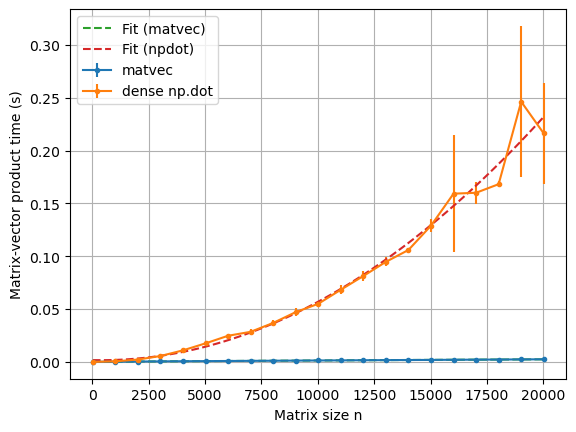

In [25]:
def plot_matvec_npdot_times(
    times_matvec_list, u_matvec_list, times_npdot_list, u_npdot_list, n_list
):
    # do second order polynomial fit
    fit_coefficients1 = np.polyfit(n_list, times_matvec_list, 2)

    fitted_function1 = np.poly1d(fit_coefficients1)

    # generate fitted function
    fit_x = np.linspace(min(n_list), max(n_list), 100)

    fit_y1 = fitted_function1(fit_x)

    # do the fitting for npdot data
    fit_coefficients2 = np.polyfit(n_list, times_npdot_list, 2)

    fitted_function2 = np.poly1d(fit_coefficients2)
    fit_y2 = fitted_function2(fit_x)

    # plotting
    plt.errorbar(
        n_list, times_matvec_list, yerr=u_matvec_list, fmt=".-", label="matvec"
    )

    plt.errorbar(
        n_list, times_npdot_list, yerr=u_npdot_list, fmt=".-", label="dense np.dot"
    )

    plt.plot(fit_x, fit_y1, "--", label="Fit (matvec)")
    plt.plot(fit_x, fit_y2, "--", label="Fit (npdot)")
    print("Fitted coefficients (matvec):", fit_coefficients1)
    print("Fitted coefficients (npdot):", fit_coefficients2)

    plt.xlabel("Matrix size n")
    plt.ylabel("Matrix-vector product time (s)")
    plt.grid()
    plt.legend()

    plt.show()


plot_matvec_npdot_times(
    times_matvec_list, u_matvec_list, times_npdot_list, u_npdot_list, n_list
)

In [26]:
times_matvec_list = []
u_matvec_list = []
times_npdot_list = []
u_npdot_list = []
n_list = np.arange(20, 20030, 1000)
for n in n_list:
    matvec_t, matvec_t_u = time_product(
        n, repetitions_number=10, matvec=True, few_elements=True
    )
    times_matvec_list.append(matvec_t)
    u_matvec_list.append(matvec_t_u)

    npdot_t, npdot_t_u = time_product(
        n, repetitions_number=10, matvec=False, few_elements=True
    )
    times_npdot_list.append(npdot_t)
    u_npdot_list.append(npdot_t_u)

Fitted coefficients (matvec): [-2.21668549e-13  1.19198952e-07  5.38304349e-05]
Fitted coefficients (npdot): [ 8.71212471e-10 -3.21227894e-06  8.32513528e-03]


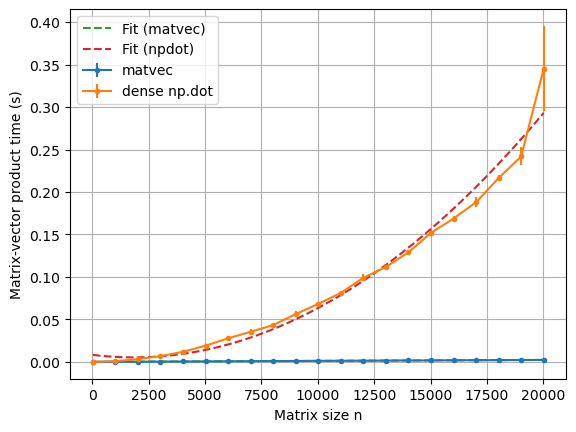

In [27]:
plot_matvec_npdot_times(
    times_matvec_list, u_matvec_list, times_npdot_list, u_npdot_list, n_list
)

It can be seen, that matvec method greately outperforms np.dot of dense representation. Before howerver, we observed that for n=1000, matvec was slower. This is becaus matvec scales significantly better with growing n, compared to np.dot of dense representation. Since matvec works in csr, it goes row by row and for each row performs operations only on few elements. That is because matrices defined above contain mostly zeros. Np.dot however, performs $n^2$ operations each time. It can be therefore concluded that in cases above, np.dot of dense representation scales as $\sim O(n^2)$ and matvec scales as $ \sim O(n) $. This is further proven by the fitted second order polynomial, which found a good quadratic fit to np.dot, but for matvec the quadratic coefficient is very small and the fit is mostly linear. 

However the cases above, as mentioned, are special cases, where most elements are 0. In case of dense matrix, matvec should lose its advantage over np.dot, this is investigated below:

In [28]:
times_matvec_list = []
u_matvec_list = []
times_npdot_list = []
u_npdot_list = []
n_list = np.arange(20, 2230, 200)
for n in n_list:
    matvec_t, matvec_t_u = time_product(
        n, repetitions_number=10, matvec=True, dense=True
    )
    times_matvec_list.append(matvec_t)
    u_matvec_list.append(matvec_t_u)

    npdot_t, npdot_t_u = time_product(
        n, repetitions_number=10, matvec=False, dense=True
    )
    times_npdot_list.append(npdot_t)
    u_npdot_list.append(npdot_t_u)

Fitted coefficients (matvec): [6.26646853e-10 1.85561538e-08 1.46646295e-04]
Fitted coefficients (npdot): [ 5.89531531e-10 -2.84478776e-07  9.77086805e-05]


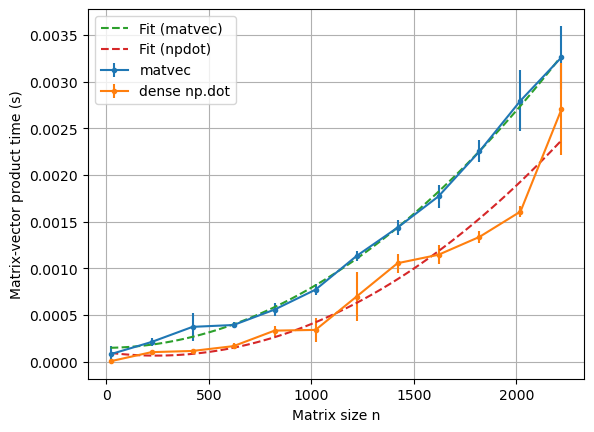

In [29]:
plot_matvec_npdot_times(
    times_matvec_list, u_matvec_list, times_npdot_list, u_npdot_list, n_list
)

As expected, this time matvec does not perform better than np.dot, but it is in fact slower for all matrix sizes n. In this case matvec for each row also needs to perform n operations, so the time performance scales as $O(n^2)$, which is well reflected in the fitted function

### Solving linear system using matvec:

create_coo_A results in positive, symmetric matrix, which can be used directly with conjugate gradient solver. Therefore this matrix is used to compare both methods.

In [30]:
coo_A = create_coo_A(50)

csr_matrix_example = CSRMatrix(coo_A)

random_vector = np.random.rand(csr_matrix_example.shape[1])


solution_gmres, info_gmres = gmres(csr_matrix_example, random_vector)

solution_cg, info_cg = cg(csr_matrix_example, random_vector)

# check if solutions equal
if np.allclose(solution_gmres, solution_cg):
    print("Solutions are the same.")
else:
    print("Solutions differ.")


print(np.max(solution_gmres - solution_cg))

Solutions differ.
1.7840129682492045e-06


Solutions differs as two methods take different paths and have different convergence. Additionally two methods giving in theory the same results, when implemented on floating point numbers might give slightly different results. It should be noted, that the differences here are very small, of order of magnitude -6. 

# Part 2: specific sparse matrix

In this part, a class for storing special case of matrix is created. The matrix in this case can be written as follows:

\begin{align*}
A &= \begin{bmatrix}
        D & 0 \\
        0 & B
     \end{bmatrix}
\end{align*}
Where the D stands for n by n diagonal matrix and B is n by n dense matrix. 

As usual, only non zero elements of the matrix should be stored. The top left n by n diagonal can be just stored as a list of n values. The bigger problem is the bottom right n by n part as it is dense and therefore will contain n by n values. This would mean that complexity of this matrix would grow with size as $O(n^2)$, which only differs by a factor of 4 from the case where entire matrix would be stored as dense. Thankfully in this specific case, bottom right n by n matrix can be written as a product of two smaller matrices: $T * M$, where T is a n by 2 matrix (tall), and M is 2 by n (wide). Since storing large dense matrix (n by n bottom right corner in this case) should be avoided, the idea is to store T and M matrices in memory instead. This way, in total, 5n elements should be stored (n for diagonal part, 2n for T matrix and 2n for M matrix). This is linear complexity O(5n) instead of quadratic, which is a good improvement. The addition method is not necessary in this case, and only matrix-vector product method is defined. Since The vector which is multiplied by 2n by 2n matrix A, should have 2n elements. The output vector also will have 2n elements. The first n elements of resulting vector are easy to compute, they are a result of multiplying diagonal part of matrix A, with first top n elements from the input vector. Therefore ith element of first half of resulting vector is equal to ith element of list storing diagonal values of D, multiplied by ith element of input vector: 

\begin{align*}
\begin{bmatrix}
    d_{11} & 0 & \cdots & 0 \\
    0 & d_{22} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & d_{nn} \\
\end{bmatrix}
\begin{bmatrix}
    v_1 \\
    v_2 \\
    \vdots \\
    v_n \\
\end{bmatrix}
=
\begin{bmatrix}
    d_{11} * v_1 \\
    d_{22} * v_2 \\
    \vdots \\
    d_{nn} * v_n \\
\end{bmatrix}
\end{align*}

The dense n by n part, is more complicated ot compute, as it was decided that T and M matrices are stored rather than the dense part directly, and also converting to dense needs to be avoided. This time, it is the bottom n elements of input vector that are used in this operation, and the result will be a vector representing bottom n elements of the total output vector. In general, in matrix-vector product, a vector is produced such that its ith element is result of dot product of ith matrix row with the entire vector. 

\begin{align*}
\begin{bmatrix}
    b_{n+1, 1} & b_{n+1, 2} & \cdots & b_{n+1, 2n} \\
    b_{n+2, 1} & b_{n+2, 2} & \cdots & b_{n+2, 2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    b_{2n, 1} & b_{2n, 2} & \cdots & b_{2n, 2n} \\
\end{bmatrix}
\begin{bmatrix}
    v_{n+1} \\
    v_{n+2} \\
    \vdots \\
    v_{2n} \\
\end{bmatrix}
=
\begin{bmatrix}
    b_{n+1, 1} * v_{n+1} +  b_{n+1, 2} * v_{n+2} + \cdots + b_{n+1, 2n} * v_{2n}\\
    b_{n+2, 1} * v_{n+1} +  b_{n+2, 2} * v_{n+2} + \cdots + b_{n+2, 2n} * v_{2n}\\
    \vdots \\
    b_{2n, 1} * v_{n+1} +  b_{2n, 2} * v_{n+2} + \cdots + b_{2n, 2n} * v_{2n}\
\end{bmatrix}
\end{align*}

To perform this calculation without dense form of matrix, this operation is done row by row, to compute element of the output vector at a time. Therefore, a row of matrix B needs to be computed from T and M matrices. This is achieved by performing dot product of a ith row from T matrix, with an entire M matrix, resulting in ith row of the dense B matrix:

$$ row_i = np.dot(T[i, :], M) $$

Next, as mentioned before, this row can be used to compute ith element of the bottom half of the output vector, by taking dot product of this row with bottom half of the input vector.

In [31]:
@numba.njit(parallel=True)
def calculate_vector_element_optimized(second_T, second_M, vector_second_half):
    n = len(second_T)
    resulting_second_half = np.empty(n)

    for i in numba.prange(n):
        row = np.dot(second_T[i, :], second_M)
        resulting_second_half[i] = np.dot(row, vector_second_half)

    return resulting_second_half

In [32]:
class Matrix_A(LinearOperator):
    def __init__(self, diag_n, T_matrix, M_matrix):
        n = len(diag_n)
        if n != T_matrix.shape[0] or n != M_matrix.shape[1]:
            raise ValueError(
                "Diagonal elements length does not match T or M matrix shapes"
            )

        self.shape = (2 * n, 2 * n)
        self.dtype = T_matrix.dtype

        # store diagonal elements, T and M matrices
        self.first_diag = diag_n
        self.second_T = T_matrix
        self.second_M = M_matrix

    def todense(self):
        """Create a dense representation of this A matrix, should only be used for small n."""

        # ask user if they want to continue, but only for sizes greater than 50
        if self.shape[0] > 50:
            user_input = input(
                f"Matrix size is {2*len(self.first_diag)}, do you wish to continue? (Y/n): "
            )

            if user_input.lower() != "y":
                print("User chose not to continue.")
                return

        n = round(self.shape[0] / 2)

        output_matrix = np.zeros((2 * n, 2 * n))
        np.fill_diagonal(output_matrix[:n, :n], self.first_diag)
        output_matrix[n:, n:] = np.dot(self.second_T, self.second_M)

        return output_matrix

    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        vector = vector.reshape(
            -1,
        )  # handle case when shape is (n,1)
        if len(vector) != self.shape[1]:
            raise ValueError("Vector shape incorrect for matvec product")

        n = round(self.shape[0] / 2)
        resulting_first_half = self.first_diag * vector[0:n]

        resulting_second_half = calculate_vector_element_optimized(
            self.second_T, self.second_M, vector[n:]
        )

        return np.concatenate((resulting_first_half, resulting_second_half), axis=None)

In [33]:
def create_random_system(n):
    """Creates elements needed for A matrix of size (2n, 2n):
    matrices T and M, a list of diagonal elements for the top left corner of A matrix,
    and vector that has appropriate shape for matvec product"""
    # create a tall matrix T (n x 2)
    T = np.random.rand(n, 2).astype(np.float32)

    # create a wide matrix M (2 x n)
    M = np.random.rand(2, n).astype(np.float32)
    diag_elements_n = np.random.rand(n).astype(np.float32)

    vec = np.random.rand(2 * n).astype(np.float32)

    return T, M, diag_elements_n, vec


def create_csr_A(T, M, diag_elements_n):
    # create csr representation of A matrix
    mat = coo_matrix(np.dot(T, M))
    n = mat.shape[0]

    col_array_dense = mat.col
    row_array_dense = mat.row
    col_array_dense = col_array_dense + n
    row_array_dense = row_array_dense + n

    # coo representation of diagonal part
    col_array_diag = np.arange(0, n)
    row_array_diag = np.arange(0, n)

    # connect lists of data, columns and rows, to form single full A matrix in coo format.
    data_array_full = np.concatenate((diag_elements_n, mat.data))
    col_array_full = np.concatenate((col_array_diag, col_array_dense))
    row_array_full = np.concatenate((row_array_diag, row_array_dense))

    # convert to csr format
    A_csr = csr_array(
        (data_array_full, (row_array_full, col_array_full)), shape=(2 * n, 2 * n)
    )

    data_array_full = np.empty_like(data_array_full)
    col_array_full = np.empty_like(col_array_full)
    row_array_full = np.empty_like(row_array_full)

    return A_csr


def create_coo_A(T, M, diag_elements_n):
    # create coo representation of A matrix
    mat = coo_matrix(np.dot(T, M))
    n = mat.shape[0]

    col_array_dense = mat.col
    row_array_dense = mat.row
    col_array_dense = col_array_dense + n
    row_array_dense = row_array_dense + n

    # coo representation of diagonal part
    col_array_diag = np.arange(0, n)
    row_array_diag = np.arange(0, n)

    # connect lists of data, columns, and rows to form a single full A matrix in coo format.
    data_array_full = np.concatenate((diag_elements_n, mat.data))
    col_array_full = np.concatenate((col_array_diag, col_array_dense))
    row_array_full = np.concatenate((row_array_diag, row_array_dense))

    # create COO format matrix
    A_coo = coo_matrix(
        (data_array_full, (row_array_full, col_array_full)), shape=(2 * n, 2 * n)
    )

    data_array_full = np.empty_like(data_array_full)
    col_array_full = np.empty_like(col_array_full)
    row_array_full = np.empty_like(row_array_full)

    return A_coo

In [34]:
# test if representation is correct, by converting to dense for small matrix sizes
for N in np.arange(3, 20, 2)[::-1]:
    T, M, diagonal_elements_n, vec = create_random_system(N)

    A = Matrix_A(diagonal_elements_n, T, M)

    A_dense = A.todense()

    np.testing.assert_allclose(
        A_dense[:N, :N],
        np.diag(diagonal_elements_n),
        err_msg="Diagonal part not matching",
    )
    np.testing.assert_allclose(
        A_dense[N:, N:], np.dot(T, M), err_msg="Dense part not matching"
    )

    A_csr = create_csr_A(T, M, diagonal_elements_n)

    np.testing.assert_allclose(
        A_csr.dot(vec), A.matvec(vec), err_msg="Matvec method error", atol=1e-5
    )


print(A_dense)
print("")
print("")
print(A_csr.toarray())

[[0.47973832 0.         0.         0.         0.         0.        ]
 [0.         0.27526131 0.         0.         0.         0.        ]
 [0.         0.         0.02909989 0.         0.         0.        ]
 [0.         0.         0.         0.41343328 0.15459594 0.51084715]
 [0.         0.         0.         0.58293158 0.20469731 0.6751982 ]
 [0.         0.         0.         0.46525687 0.07359692 0.23409252]]


[[0.47973832 0.         0.         0.         0.         0.        ]
 [0.         0.2752613  0.         0.         0.         0.        ]
 [0.         0.         0.02909989 0.         0.         0.        ]
 [0.         0.         0.         0.41343328 0.15459594 0.51084715]
 [0.         0.         0.         0.5829316  0.20469731 0.6751982 ]
 [0.         0.         0.         0.46525687 0.07359692 0.23409252]]


As expected, the matrices representations are the same.

In [35]:
# functions to help time matvec and np.dot
def time_matvec(n):
    T, M, diag_elements_n, vec = create_random_system(n)
    mat_A = Matrix_A(diag_elements_n, T, M)

    # measure matvec time
    start_time = timeit.default_timer()
    mat_A.matvec(vec)
    end_time = timeit.default_timer()

    return end_time - start_time


def time_csr(n):
    T, M, diag_elements_n, vec = create_random_system(n)
    A_csr = create_csr_A(T, M, diag_elements_n)

    # measure dot product time
    start_time = timeit.default_timer()
    A_csr.dot(vec)
    end_time = timeit.default_timer()

    return end_time - start_time

In [36]:
# repeat timing multiple times, in order to increase reliability of result
# handles both matvec and np.dot of csr
def time_product(n, repetitions_number, matvec=True):
    execution_times_array = np.zeros(repetitions_number)

    for m_no in range(repetitions_number):
        if matvec == True:
            execution_time = time_matvec(n)
        else:
            execution_time = time_csr(n)

        execution_times_array[m_no] = execution_time

    uncertainty = np.sqrt(np.var(execution_times_array))

    return np.mean(execution_times_array), uncertainty

In [37]:
times_matvec_list = []
u_matvec_list = []
times_csr_list = []
u_csr_list = []
n_list = np.arange(20, 4000, 200)
for n in n_list:
    matvec_t, matvec_t_u = time_product(n, repetitions_number=50, matvec=True)
    times_matvec_list.append(matvec_t)
    u_matvec_list.append(matvec_t_u)

    csr_t, csr_t_u = time_product(n, repetitions_number=50, matvec=False)
    times_csr_list.append(csr_t)
    u_csr_list.append(csr_t_u)

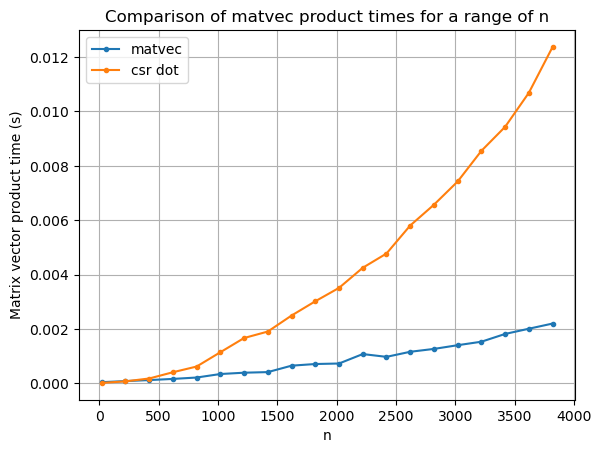

In [38]:
plt.title("Comparison of matvec product times for a range of n")
plt.plot(n_list, times_matvec_list, ".-", label="matvec")
plt.plot(n_list, times_csr_list, ".-", label="csr dot")
plt.xlabel("n")
plt.ylabel("Matrix vector product time (s)")
plt.grid()
plt.legend()

It can be seen, that matvec outperforms scipy's csr_matrix.dot. This is interesting as in theory, number of operations should be similar. The main reasons why matvec implementation is faster is probably the usage of numba.

The greatest adventage of this special class is however the memory usage, as explained in the introduction to this part. The csr representation of our matrix A, can be expected to have n values in each data, indices and indptr arrays. It also should have n^2 values for data and indices arrays in the dense part, and n elements in indptr array for this part. The total complexity can be expressed as $O(2n^2 + 4n)$. In our Matrix_A class, diagonal elements will have n values, and matrice T and M will each have 2n elements. The total complexity should therefore be $O(5n). Our class scales linearly in memory complexity, which is much better than csr or coo representations in this case. We can investigate that further with asizeof function which gives an estimation of memory size of an object. For example:

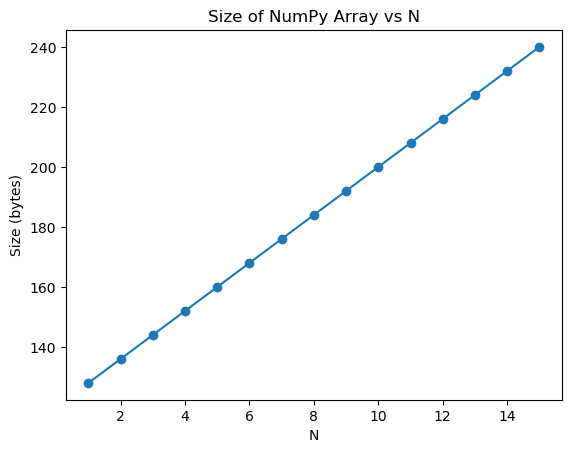

In [39]:
def get_array_size(N):
    return asizeof.asizeof(np.random.rand(N))


N_values = range(1, 16)

# calculate sizes for each N
sizes = [get_array_size(N) for N in N_values]

plt.plot(N_values, sizes, marker="o")
plt.title("Size of NumPy Array vs N")
plt.xlabel("N")
plt.ylabel("Size (bytes)")
plt.show()

As expected memory size of this simple array grows as 8n as there are 8 bytes per float64 number.

In [40]:
def Matrix_A_size(n):
    T, M, diag_elements_n, vec = create_random_system(n)
    mat_A = Matrix_A(diag_elements_n, T, M)

    return [
        asizeof.asizeof(mat_A),
        asizeof.asizeof(mat_A.first_diag),
        asizeof.asizeof(mat_A.second_T),
        asizeof.asizeof(mat_A.second_M),
    ]


def csr_A_size(n):
    T, M, diag_elements_n, _ = create_random_system(n)
    A_csr = create_csr_A(T, M, diag_elements_n)
    return [
        asizeof.asizeof(A_csr),
        asizeof.asizeof(A_csr.data),
        asizeof.asizeof(A_csr.indices),
        asizeof.asizeof(A_csr.indptr),
    ]

In [41]:
n_list = np.arange(10, 5000, 200)
Matrix_A_size_list = []
csr_A_size_list = []
for n in n_list:
    Matrix_A_size_list.append(Matrix_A_size(n))
    csr_A_size_list.append(csr_A_size(n))

Matrix_A_sizes = np.array(Matrix_A_size_list).T[0]
Matrix_A_diag_sizes = np.array(Matrix_A_size_list).T[1]
Matrix_A_T_sizes = np.array(Matrix_A_size_list).T[2]
Matrix_A_M_sizes = np.array(Matrix_A_size_list).T[3]

csr_A_sizes = np.array(csr_A_size_list).T[0]
csr_A_data_sizes = np.array(csr_A_size_list).T[1]
csr_A_indices_sizes = np.array(csr_A_size_list).T[2]
csr_A_indptr_sizes = np.array(csr_A_size_list).T[3]

Fitted Slope: 20.00
Fitted Offset: 1027.16


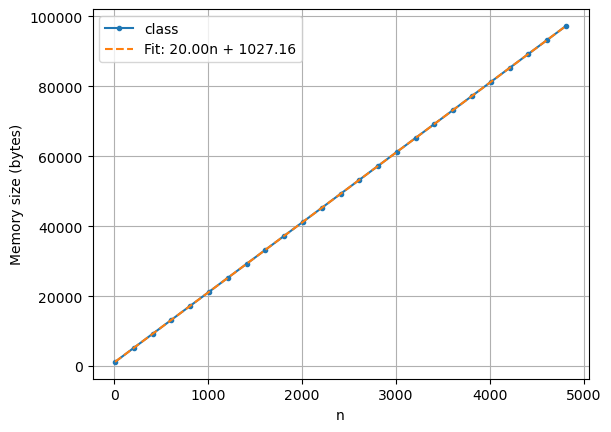

Fitted Coefficients: 8.00, 16.01, 1254.06


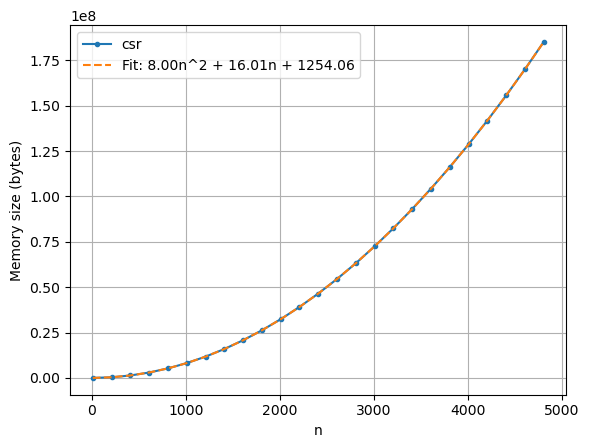

In [42]:
# do second order polynomial fit
fit_coefficients = np.polyfit(n_list, Matrix_A_sizes, 1)
fit_line = np.poly1d(fit_coefficients)


plt.plot(n_list, Matrix_A_sizes, ".-", label="class")
plt.plot(
    n_list,
    fit_line(n_list),
    "--",
    label=f"Fit: {fit_coefficients[0]:.2f}n + {fit_coefficients[1]:.2f}",
)
plt.grid()
plt.legend()


slope, offset = fit_coefficients
print(f"Fitted Slope: {slope:.2f}")
print(f"Fitted Offset: {offset:.2f}")

plt.ylabel("Memory size (bytes)")
plt.xlabel("n")
plt.show()

# do second order polynomial fit
fit_coefficients_csr = np.polyfit(n_list, csr_A_sizes, 2)
fit_quadratic_csr = np.poly1d(fit_coefficients_csr)


plt.plot(n_list, csr_A_sizes, ".-", label="csr")
plt.plot(
    n_list,
    fit_quadratic_csr(n_list),
    "--",
    label=f"Fit: {fit_coefficients_csr[0]:.2f}n^2 + {fit_coefficients_csr[1]:.2f}n + {fit_coefficients_csr[2]:.2f}",
)
plt.grid()
plt.legend()


coeff_a, coeff_b, coeff_c = fit_coefficients_csr
print(f"Fitted Coefficients: {coeff_a:.2f}, {coeff_b:.2f}, {coeff_c:.2f}")

plt.ylabel("Memory size (bytes)")
plt.xlabel("n")
plt.show()

Results match perfectly what was described before. This time, float32 are used which have 4 byteds. Thus csr grows as $4* (2n^2 + 4n)$ and Matrix_A as $4* 5n$.

# References
[1] Saad, Y. (2003). 'Iterative Methods for Sparse Linear Systems'. Society for Industrial and Applied Mathematics \
[2] SciPy v1.11.4 Manual (2023). scipy.sparse.linalg.LinearOperator. Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html (Accessed: 30/11/2023) 